In [1]:
import os
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from keras.models import Model,load_model,Sequential
from keras.applications.xception import  Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import  ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import keras.callbacks as kcallbacks
import keras
from keras.preprocessing.image import load_img,img_to_array
import math
import random
from keras.utils import plot_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from PIL import Image
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
#generate training and test images
TARGET_SIZE=(224,224)
INPUT_SIZE=(224,224,3)
BATCHSIZE=128	#could try 128 or 32

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        './test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='binary')

Found 385 images belonging to 2 classes.


Found 385 images belonging to 2 classes.


In [3]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [4]:
history_this= LossHistory()


***CNN BASELINE***

In [5]:
def cnn_by_own(input_shape,num_class,epochs,savepath='./model_own.h5'):
    model = Sequential()
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=input_shape,padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='glorot_uniform'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_acc', patience=2, verbose=1, mode='auto')
    
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_acc', verbose=1, save_best_only=False, mode='auto')
    start_time = time.time()

    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping,saveBestModel,history_this],
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f'Total training time: {training_time} seconds')




Epoch 1/20


4/4 [==============================] - ETA: 0s - loss: 0.4809 - accuracy: 0.6545 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 1: saving model to .\model_own.h5
4/4 [==============================] - 166s 41s/step - loss: 0.4809 - accuracy: 0.6545 - val_loss: 2.5838 - val_accuracy: 0.9377
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.7733 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy

Epoch 2: saving model to .\model_own.h5
4/4 [==============================] - 191s 49s/step - loss: 0.7733 - accuracy: 0.9636 - val_loss: 0.3628 - val_accuracy: 0.9377
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.3733 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not av

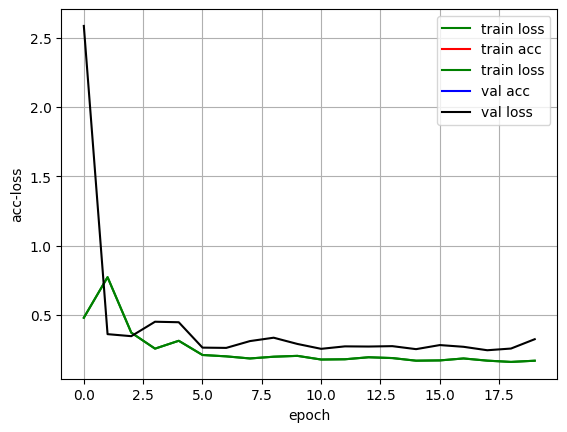

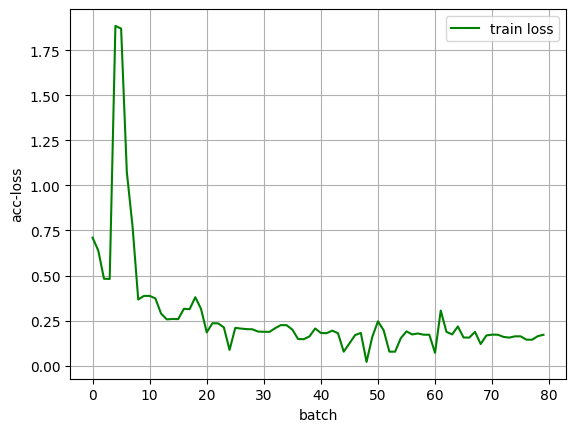

In [6]:
cnn_by_own(input_shape=INPUT_SIZE,num_class=2,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

***XCEPTION NET***


In [7]:
def xception( num_class, epochs,savepath='./xception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:131]:		#could be tuned to be 50, 100, or 131
        layer.trainable = False
    for layer in model_fine_tune.layers[131:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(1, activation='sigmoid')(model)
    model = Model(model_fine_tune.input, model, name='xception')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=3, verbose=1, mode='auto')	#patience could be tuned by 2 and 3
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=False,
        mode='auto')
    
    start_time = time.time()

    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f'Total training time: {training_time} seconds')

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.3676 - accuracy: 0.8312WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 1: saving model to .\xception.h5
4/4 [==============================] - 56s 14s/step - loss: 0.3676 - accuracy: 0.8312 - val_loss: 0.3747 - val_accuracy: 0.9377
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 2: saving model to .\xception.h5
4/4 [==============================] - 48s 13s/step - loss: 0.2055 - accuracy: 0.9636 - val_loss: 0.3814 - val_accuracy: 0.9377
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 3: saving model to .\xception.h5
4/4 [==============================] - 47s 13s/step - loss: 0.2002 - accuracy: 0.9636 - val_loss: 0.3060 - val_accuracy: 0.9377
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 4: saving model to .\xception.h5
4/4 [==============================] - 48s 13s/step - loss: 0.1654 - accuracy: 0.9636 - val_loss: 0.2139 - val_accuracy: 0.9377
Epoch 5/20
4/4 [==============================] - ETA: 0s - loss: 0.1177 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 5: saving model to .\xception.h5
4/4 [==============================] - 47s 13s/step - loss: 0.1177 - accuracy: 0.9636 - val_loss: 0.1528 - val_accuracy: 0.9377
Epoch 6/20
4/4 [==============================] - ETA: 0s - loss: 0.0933 - accuracy: 0.9610WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 6: saving model to .\xception.h5
4/4 [==============================] - 48s 13s/step - loss: 0.0933 - accuracy: 0.9610 - val_loss: 0.1185 - val_accuracy: 0.9403
Epoch 7/20
4/4 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9714WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 7: saving model to .\xception.h5
4/4 [==============================] - 48s 13s/step - loss: 0.0859 - accuracy: 0.9714 - val_loss: 0.1031 - val_accuracy: 0.9455
Epoch 8/20
4/4 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9662WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 8: saving model to .\xception.h5
4/4 [==============================] - 47s 13s/step - loss: 0.0753 - accuracy: 0.9662 - val_loss: 0.0983 - val_accuracy: 0.9506
Epoch 9/20
4/4 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9740WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 9: saving model to .\xception.h5
4/4 [==============================] - 47s 13s/step - loss: 0.0651 - accuracy: 0.9740 - val_loss: 0.0996 - val_accuracy: 0.9506
Epoch 10/20
4/4 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9714WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 10: saving model to .\xception.h5
4/4 [==============================] - 47s 13s/step - loss: 0.0586 - accuracy: 0.9714 - val_loss: 0.0888 - val_accuracy: 0.9584
Epoch 11/20
4/4 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9818WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 11: saving model to .\xception.h5
4/4 [==============================] - 47s 13s/step - loss: 0.0501 - accuracy: 0.9818 - val_loss: 0.0696 - val_accuracy: 0.9662
Epoch 12/20
4/4 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9818WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 12: saving model to .\xception.h5
4/4 [==============================] - 49s 13s/step - loss: 0.0390 - accuracy: 0.9818 - val_loss: 0.0618 - val_accuracy: 0.9714
Epoch 13/20
4/4 [==============================] - ETA: 0s - loss: 0.0359 - accuracy: 0.9870WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 13: saving model to .\xception.h5
4/4 [==============================] - 47s 16s/step - loss: 0.0359 - accuracy: 0.9870 - val_loss: 0.0592 - val_accuracy: 0.9792
Epoch 14/20
4/4 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9792WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 14: saving model to .\xception.h5
4/4 [==============================] - 55s 18s/step - loss: 0.0353 - accuracy: 0.9792 - val_loss: 0.0599 - val_accuracy: 0.9766
Epoch 15/20
4/4 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.9896 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 15: saving model to .\xception.h5
4/4 [==============================] - 59s 16s/step - loss: 0.0324 - accuracy: 0.9896 - val_loss: 0.0585 - val_accuracy: 0.9766
Epoch 16/20
4/4 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9922WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 16: saving model to .\xception.h5
4/4 [==============================] - 53s 15s/step - loss: 0.0279 - accuracy: 0.9922 - val_loss: 0.0603 - val_accuracy: 0.9766
Epoch 17/20
4/4 [==============================] - ETA: 0s - loss: 0.0307 - accuracy: 0.9896WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 17: saving model to .\xception.h5
4/4 [==============================] - 53s 15s/step - loss: 0.0307 - accuracy: 0.9896 - val_loss: 0.0627 - val_accuracy: 0.9766
Epoch 18/20
4/4 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9922WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 18: saving model to .\xception.h5
4/4 [==============================] - 53s 14s/step - loss: 0.0240 - accuracy: 0.9922 - val_loss: 0.0579 - val_accuracy: 0.9818
Epoch 19/20
4/4 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9948 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 19: saving model to .\xception.h5
4/4 [==============================] - 56s 19s/step - loss: 0.0177 - accuracy: 0.9948 - val_loss: 0.0570 - val_accuracy: 0.9818
Epoch 20/20
4/4 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.9948WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 20: saving model to .\xception.h5
4/4 [==============================] - 60s 17s/step - loss: 0.0228 - accuracy: 0.9948 - val_loss: 0.0675 - val_accuracy: 0.9766
Total training time: 1017.2104799747467 seconds


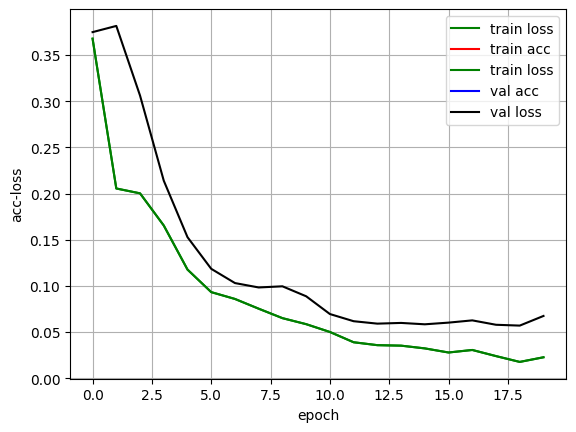

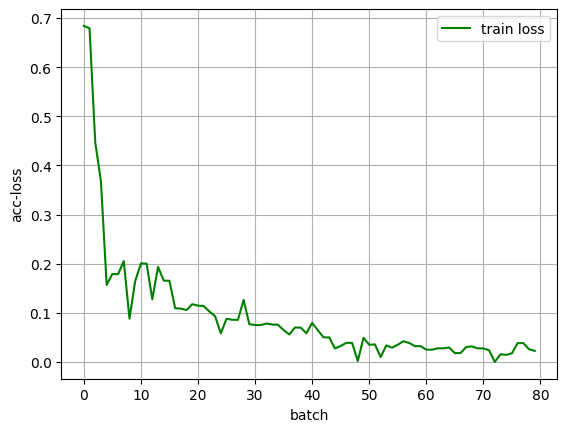

In [8]:
xception(num_class=2,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

***VGG16***

In [9]:
def vgg16( num_class, epochs,savepath='./VGG16.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:15]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[15:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output) #GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(1, activation='sigmoid')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=False,
        mode='auto')
    start_time = time.time()
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f'Total training time: {training_time} seconds')




Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.9640 - accuracy: 0.8208 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 1: saving model to .\VGG16.h5
4/4 [==============================] - 161s 44s/step - loss: 0.9640 - accuracy: 0.8208 - val_loss: 0.8551 - val_accuracy: 0.0623
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.4995 - accuracy: 0.7870 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 2: saving model to .\VGG16.h5
4/4 [==============================] - 154s 42s/step - loss: 0.4995 - accuracy: 0.7870 - val_loss: 0.4497 - val_accuracy: 0.9377
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.3159 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 3: saving model to .\VGG16.h5
4/4 [==============================] - 162s 54s/step - loss: 0.3159 - accuracy: 0.9636 - val_loss: 0.2743 - val_accuracy: 0.9377
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.2248 - accuracy: 0.9506 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 4: saving model to .\VGG16.h5
4/4 [==============================] - 159s 44s/step - loss: 0.2248 - accuracy: 0.9506 - val_loss: 0.2982 - val_accuracy: 0.9377
Epoch 5/20
4/4 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 5: saving model to .\VGG16.h5
4/4 [==============================] - 160s 42s/step - loss: 0.2063 - accuracy: 0.9636 - val_loss: 0.3574 - val_accuracy: 0.9377
Epoch 6/20
4/4 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 6: saving model to .\VGG16.h5
4/4 [==============================] - 142s 47s/step - loss: 0.2340 - accuracy: 0.9636 - val_loss: 0.2532 - val_accuracy: 0.9377
Epoch 7/20
4/4 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 7: saving model to .\VGG16.h5
4/4 [==============================] - 136s 37s/step - loss: 0.1629 - accuracy: 0.9636 - val_loss: 0.2268 - val_accuracy: 0.9377
Epoch 8/20
4/4 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9610 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 8: saving model to .\VGG16.h5
4/4 [==============================] - 141s 38s/step - loss: 0.2151 - accuracy: 0.9610 - val_loss: 0.3239 - val_accuracy: 0.9377
Epoch 9/20
4/4 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 9: saving model to .\VGG16.h5
4/4 [==============================] - 1202s 401s/step - loss: 0.2003 - accuracy: 0.9636 - val_loss: 0.2000 - val_accuracy: 0.9377
Epoch 10/20
4/4 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 10: saving model to .\VGG16.h5
4/4 [==============================] - 115s 32s/step - loss: 0.1345 - accuracy: 0.9636 - val_loss: 0.1737 - val_accuracy: 0.9377
Epoch 11/20
4/4 [==============================] - ETA: 0s - loss: 0.1197 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 11: saving model to .\VGG16.h5
4/4 [==============================] - 142s 39s/step - loss: 0.1197 - accuracy: 0.9636 - val_loss: 0.1668 - val_accuracy: 0.9377
Epoch 12/20
4/4 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 12: saving model to .\VGG16.h5
4/4 [==============================] - 141s 38s/step - loss: 0.0864 - accuracy: 0.9636 - val_loss: 0.1013 - val_accuracy: 0.9377
Epoch 13/20
4/4 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 13: saving model to .\VGG16.h5
4/4 [==============================] - 141s 39s/step - loss: 0.0699 - accuracy: 0.9636 - val_loss: 0.1044 - val_accuracy: 0.9532
Epoch 14/20
4/4 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9948  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 14: saving model to .\VGG16.h5
4/4 [==============================] - 141s 47s/step - loss: 0.0269 - accuracy: 0.9948 - val_loss: 0.0201 - val_accuracy: 0.9974
Epoch 15/20
4/4 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9922 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 15: saving model to .\VGG16.h5
4/4 [==============================] - 141s 38s/step - loss: 0.0252 - accuracy: 0.9922 - val_loss: 0.0122 - val_accuracy: 0.9974
Epoch 16/20
4/4 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9974 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 16: saving model to .\VGG16.h5
4/4 [==============================] - 141s 39s/step - loss: 0.0124 - accuracy: 0.9974 - val_loss: 0.0402 - val_accuracy: 0.9870
Epoch 17/20
4/4 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9948 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 17: saving model to .\VGG16.h5
4/4 [==============================] - 141s 39s/step - loss: 0.0213 - accuracy: 0.9948 - val_loss: 0.0102 - val_accuracy: 0.9948
Epoch 18/20
4/4 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9948 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 18: saving model to .\VGG16.h5
4/4 [==============================] - 141s 38s/step - loss: 0.0086 - accuracy: 0.9948 - val_loss: 0.0101 - val_accuracy: 0.9948
Epoch 19/20
4/4 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000   WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 19: saving model to .\VGG16.h5
4/4 [==============================] - 141s 39s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0439 - val_accuracy: 0.9870
Epoch 20/20
4/4 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9922     WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 20: saving model to .\VGG16.h5
4/4 [==============================] - 141s 39s/step - loss: 0.0290 - accuracy: 0.9922 - val_loss: 0.0117 - val_accuracy: 0.9974
Total training time: 3944.638034105301 seconds


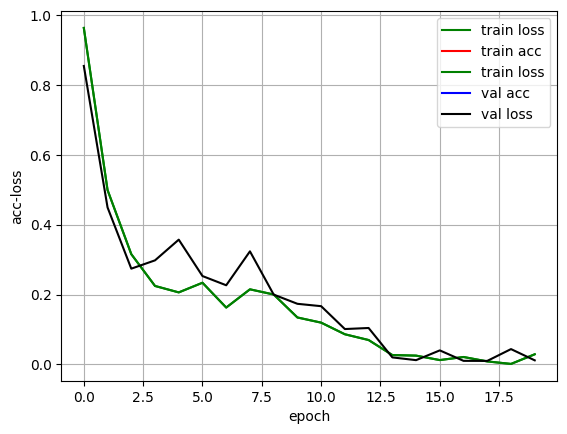

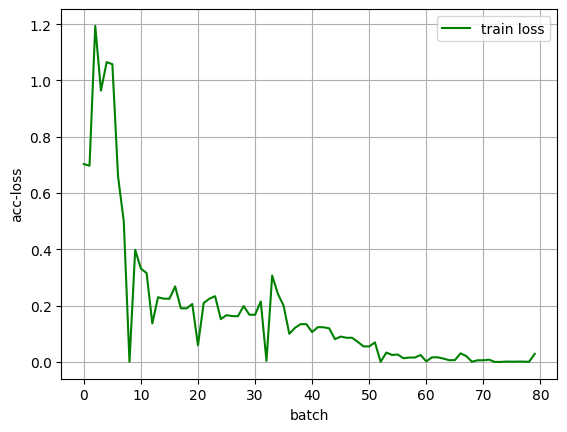

In [10]:
vgg16(num_class=2,epochs=20)	#tf36cnn
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

***VGG19***

In [11]:
def vgg19( num_class, epochs,savepath='./VGG19.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:19]:	#the number of frozen layers for transfer learning, have tuned from 5-18
        layer.trainable = False
    for layer in model_fine_tune.layers[19:]:
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(1, activation='sigmoid')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])	#set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=False,
        mode='auto')
    
    start_time = time.time()

    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f'Total training time: {training_time} seconds')

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.6623 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 1: saving model to .\VGG19.h5
4/4 [==============================] - 175s 47s/step - loss: 0.6084 - accuracy: 0.6623 - val_loss: 0.2314 - val_accuracy: 0.9377
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 2: saving model to .\VGG19.h5
4/4 [==============================] - 167s 46s/step - loss: 0.2081 - accuracy: 0.9636 - val_loss: 0.3040 - val_accuracy: 0.9377
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.9481 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 3: saving model to .\VGG19.h5
4/4 [==============================] - 167s 46s/step - loss: 0.2125 - accuracy: 0.9481 - val_loss: 0.3424 - val_accuracy: 0.9377
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.2216 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 4: saving model to .\VGG19.h5
4/4 [==============================] - 167s 46s/step - loss: 0.2216 - accuracy: 0.9636 - val_loss: 0.2527 - val_accuracy: 0.9377
Epoch 5/20
4/4 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 5: saving model to .\VGG19.h5
4/4 [==============================] - 167s 46s/step - loss: 0.1598 - accuracy: 0.9636 - val_loss: 0.2393 - val_accuracy: 0.9377
Epoch 6/20
4/4 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9636  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 6: saving model to .\VGG19.h5
4/4 [==============================] - 227s 76s/step - loss: 0.1412 - accuracy: 0.9636 - val_loss: 0.1878 - val_accuracy: 0.9377
Epoch 7/20
4/4 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 7: saving model to .\VGG19.h5
4/4 [==============================] - 123s 34s/step - loss: 0.1179 - accuracy: 0.9636 - val_loss: 0.1607 - val_accuracy: 0.9377
Epoch 8/20
4/4 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 8: saving model to .\VGG19.h5
4/4 [==============================] - 122s 41s/step - loss: 0.1011 - accuracy: 0.9636 - val_loss: 0.1048 - val_accuracy: 0.9377
Epoch 9/20
4/4 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9662 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 9: saving model to .\VGG19.h5
4/4 [==============================] - 126s 42s/step - loss: 0.0687 - accuracy: 0.9662 - val_loss: 0.0720 - val_accuracy: 0.9662
Epoch 10/20
4/4 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9792 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 10: saving model to .\VGG19.h5
4/4 [==============================] - 123s 33s/step - loss: 0.0477 - accuracy: 0.9792 - val_loss: 0.0596 - val_accuracy: 0.9792
Epoch 11/20
4/4 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9922  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 11: saving model to .\VGG19.h5
4/4 [==============================] - 129s 43s/step - loss: 0.0221 - accuracy: 0.9922 - val_loss: 0.0402 - val_accuracy: 0.9974
Epoch 12/20
4/4 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 12: saving model to .\VGG19.h5
4/4 [==============================] - 155s 43s/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.0465 - val_accuracy: 0.9922
Epoch 13/20
4/4 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9870 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 13: saving model to .\VGG19.h5
4/4 [==============================] - 171s 48s/step - loss: 0.0399 - accuracy: 0.9870 - val_loss: 0.0464 - val_accuracy: 0.9948
Epoch 14/20
4/4 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9766 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 14: saving model to .\VGG19.h5
4/4 [==============================] - 162s 44s/step - loss: 0.0854 - accuracy: 0.9766 - val_loss: 0.0348 - val_accuracy: 0.9974
Epoch 15/20
4/4 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 15: saving model to .\VGG19.h5
4/4 [==============================] - 157s 42s/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0365 - val_accuracy: 0.9974
Epoch 16/20
4/4 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9948 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 16: saving model to .\VGG19.h5
4/4 [==============================] - 157s 44s/step - loss: 0.0128 - accuracy: 0.9948 - val_loss: 0.0640 - val_accuracy: 0.9870
Epoch 17/20
4/4 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9948 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 17: saving model to .\VGG19.h5
4/4 [==============================] - 163s 45s/step - loss: 0.0081 - accuracy: 0.9948 - val_loss: 0.0340 - val_accuracy: 0.9974
Epoch 18/20
4/4 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 18: saving model to .\VGG19.h5
4/4 [==============================] - 164s 45s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0353 - val_accuracy: 0.9974
Epoch 19/20
4/4 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 19: saving model to .\VGG19.h5
4/4 [==============================] - 163s 45s/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0362 - val_accuracy: 0.9974
Epoch 20/20
4/4 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 20: saving model to .\VGG19.h5
4/4 [==============================] - 164s 45s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0432 - val_accuracy: 0.9974
Total training time: 3148.874186515808 seconds


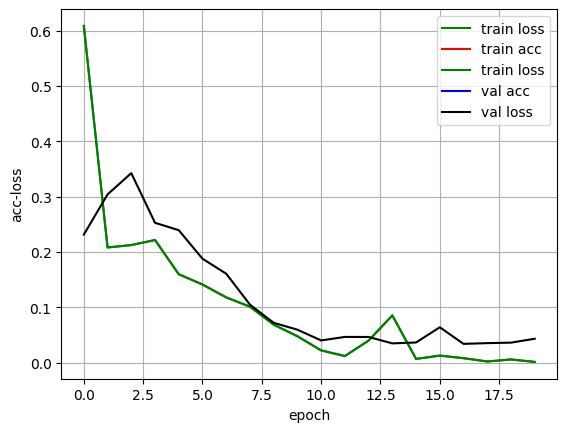

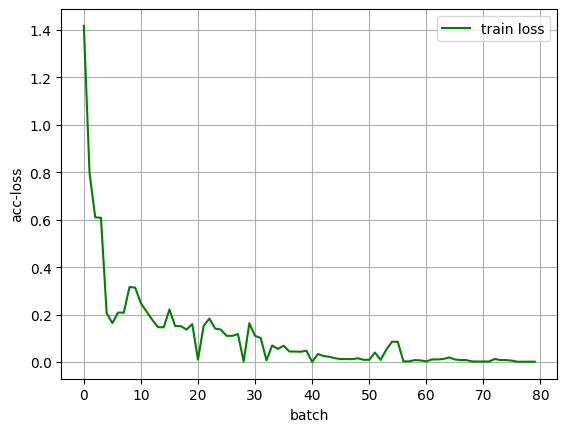

In [12]:
vgg19(num_class=2,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

ResNet

In [13]:
def resnet( num_class, epochs,savepath='./resnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:120]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[120:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(1, activation='sigmoid')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=False,
        mode='auto')
    start_time = time.time()

    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f'Total training time: {training_time} seconds')


Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.5295 - accuracy: 0.7247WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 1: saving model to .\resnet.h5
4/4 [==============================] - 61s 15s/step - loss: 0.5295 - accuracy: 0.7247 - val_loss: 0.5297 - val_accuracy: 0.9377
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9636  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 2: saving model to .\resnet.h5
4/4 [==============================] - 51s 17s/step - loss: 0.1588 - accuracy: 0.9636 - val_loss: 0.9603 - val_accuracy: 0.9377
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 3: saving model to .\resnet.h5
4/4 [==============================] - 52s 14s/step - loss: 0.1412 - accuracy: 0.9636 - val_loss: 1.4727 - val_accuracy: 0.9377
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.1230 - accuracy: 0.9636WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 4: saving model to .\resnet.h5
4/4 [==============================] - 51s 14s/step - loss: 0.1230 - accuracy: 0.9636 - val_loss: 3.9033 - val_accuracy: 0.9377
Epoch 5/20
4/4 [==============================] - ETA: 0s - loss: 0.1295 - accuracy: 0.9584WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 5: saving model to .\resnet.h5
4/4 [==============================] - 51s 14s/step - loss: 0.1295 - accuracy: 0.9584 - val_loss: 11.4509 - val_accuracy: 0.9377
Epoch 6/20
4/4 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.9636 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 6: saving model to .\resnet.h5
4/4 [==============================] - 51s 14s/step - loss: 0.1970 - accuracy: 0.9636 - val_loss: 17.3766 - val_accuracy: 0.9377
Epoch 7/20
4/4 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9818WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 7: saving model to .\resnet.h5
4/4 [==============================] - 52s 14s/step - loss: 0.0497 - accuracy: 0.9818 - val_loss: 51.6593 - val_accuracy: 0.9377
Epoch 8/20
4/4 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9844WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 8: saving model to .\resnet.h5
4/4 [==============================] - 52s 14s/step - loss: 0.0259 - accuracy: 0.9844 - val_loss: 108.3535 - val_accuracy: 0.9377
Epoch 9/20
4/4 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9922WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 9: saving model to .\resnet.h5
4/4 [==============================] - 52s 14s/step - loss: 0.0173 - accuracy: 0.9922 - val_loss: 150.0467 - val_accuracy: 0.9377
Epoch 10/20
4/4 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9974 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 10: saving model to .\resnet.h5
4/4 [==============================] - 62s 17s/step - loss: 0.0106 - accuracy: 0.9974 - val_loss: 188.8116 - val_accuracy: 0.9377
Epoch 11/20
4/4 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 11: saving model to .\resnet.h5
4/4 [==============================] - 57s 15s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 212.1527 - val_accuracy: 0.9377
Epoch 12/20
4/4 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 12: saving model to .\resnet.h5
4/4 [==============================] - 56s 15s/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 207.2381 - val_accuracy: 0.9377
Epoch 13/20
4/4 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 13: saving model to .\resnet.h5
4/4 [==============================] - 58s 15s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 184.0589 - val_accuracy: 0.9377
Epoch 14/20
4/4 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 14: saving model to .\resnet.h5
4/4 [==============================] - 56s 19s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 160.8470 - val_accuracy: 0.9377
Epoch 15/20
4/4 [==============================] - ETA: 0s - loss: 8.9932e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 15: saving model to .\resnet.h5
4/4 [==============================] - 60s 16s/step - loss: 8.9932e-04 - accuracy: 1.0000 - val_loss: 141.9873 - val_accuracy: 0.9377
Epoch 16/20
4/4 [==============================] - ETA: 0s - loss: 5.0655e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 16: saving model to .\resnet.h5
4/4 [==============================] - 58s 15s/step - loss: 5.0655e-04 - accuracy: 1.0000 - val_loss: 125.1788 - val_accuracy: 0.9377
Epoch 17/20
4/4 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000    WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 17: saving model to .\resnet.h5
4/4 [==============================] - 50s 17s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 108.7184 - val_accuracy: 0.9377
Epoch 18/20
4/4 [==============================] - ETA: 0s - loss: 7.6777e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 18: saving model to .\resnet.h5
4/4 [==============================] - 50s 13s/step - loss: 7.6777e-04 - accuracy: 1.0000 - val_loss: 92.5876 - val_accuracy: 0.9377
Epoch 19/20
4/4 [==============================] - ETA: 0s - loss: 3.2795e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 19: saving model to .\resnet.h5
4/4 [==============================] - 51s 14s/step - loss: 3.2795e-04 - accuracy: 1.0000 - val_loss: 78.5959 - val_accuracy: 0.9377
Epoch 20/20
4/4 [==============================] - ETA: 0s - loss: 5.2977e-04 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 20: saving model to .\resnet.h5
4/4 [==============================] - 55s 18s/step - loss: 5.2977e-04 - accuracy: 1.0000 - val_loss: 66.0930 - val_accuracy: 0.9377
Total training time: 1086.958327293396 seconds


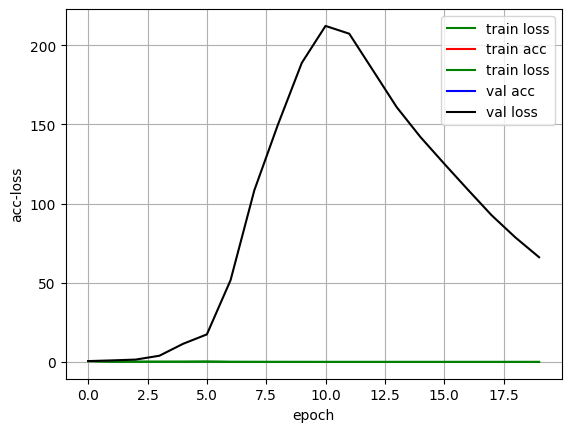

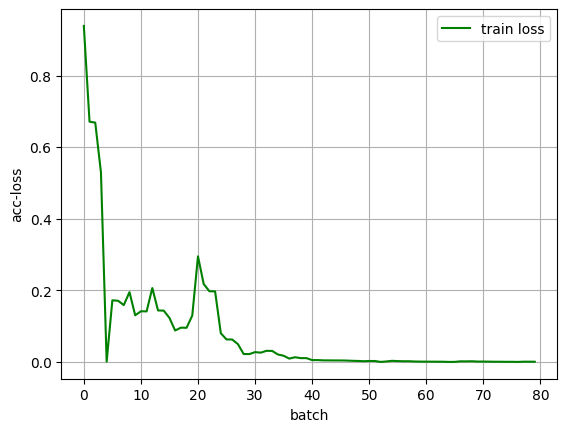

In [14]:
resnet(num_class=2,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

***Inception***

In [15]:
def inception( num_class, epochs,savepath='./inception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:35]:	#the number of frozen layers for transfer learning, have tuned from 50-150
        layer.trainable = False
    for layer in model_fine_tune.layers[35:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(1, activation='sigmoid')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=False,
        mode='auto')
    start_time = time.time()

    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f'Total training time: {training_time} seconds')

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.3645 - accuracy: 0.7740WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 1: saving model to .\inception.h5
4/4 [==============================] - 59s 12s/step - loss: 0.3645 - accuracy: 0.7740 - val_loss: 4.3405 - val_accuracy: 0.9377
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9662WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 2: saving model to .\inception.h5
4/4 [==============================] - 43s 11s/step - loss: 0.1293 - accuracy: 0.9662 - val_loss: 13.1924 - val_accuracy: 0.9377
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9714 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 3: saving model to .\inception.h5
4/4 [==============================] - 43s 14s/step - loss: 0.0274 - accuracy: 0.9714 - val_loss: 9.9300 - val_accuracy: 0.9377
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9922  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 4: saving model to .\inception.h5
4/4 [==============================] - 43s 14s/step - loss: 0.0242 - accuracy: 0.9922 - val_loss: 8.5662 - val_accuracy: 0.9377
Epoch 5/20
4/4 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 5: saving model to .\inception.h5
4/4 [==============================] - 42s 11s/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 7.9065 - val_accuracy: 0.9377
Epoch 6/20
4/4 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 6: saving model to .\inception.h5
4/4 [==============================] - 42s 11s/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 6.6011 - val_accuracy: 0.9377
Epoch 7/20
4/4 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 7: saving model to .\inception.h5
4/4 [==============================] - 42s 11s/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 4.7849 - val_accuracy: 0.9377
Epoch 8/20
4/4 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 8: saving model to .\inception.h5
4/4 [==============================] - 45s 11s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 3.0329 - val_accuracy: 0.9377
Epoch 9/20
4/4 [==============================] - ETA: 0s - loss: 6.2432e-04 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 9: saving model to .\inception.h5
4/4 [==============================] - 45s 11s/step - loss: 6.2432e-04 - accuracy: 1.0000 - val_loss: 1.3450 - val_accuracy: 0.9377
Epoch 10/20
4/4 [==============================] - ETA: 0s - loss: 3.1392e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 10: saving model to .\inception.h5
4/4 [==============================] - 42s 14s/step - loss: 3.1392e-04 - accuracy: 1.0000 - val_loss: 0.2267 - val_accuracy: 0.9610
Epoch 11/20
4/4 [==============================] - ETA: 0s - loss: 7.9248e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 11: saving model to .\inception.h5
4/4 [==============================] - 43s 11s/step - loss: 7.9248e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 12/20
4/4 [==============================] - ETA: 0s - loss: 1.8936e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 12: saving model to .\inception.h5
4/4 [==============================] - 43s 11s/step - loss: 1.8936e-04 - accuracy: 1.0000 - val_loss: 0.1659 - val_accuracy: 0.9688
Epoch 13/20
4/4 [==============================] - ETA: 0s - loss: 1.5292e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 13: saving model to .\inception.h5
4/4 [==============================] - 42s 11s/step - loss: 1.5292e-04 - accuracy: 1.0000 - val_loss: 0.9515 - val_accuracy: 0.8286
Epoch 14/20
4/4 [==============================] - ETA: 0s - loss: 1.1318e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 14: saving model to .\inception.h5
4/4 [==============================] - 43s 11s/step - loss: 1.1318e-04 - accuracy: 1.0000 - val_loss: 2.7060 - val_accuracy: 0.6052
Epoch 15/20
4/4 [==============================] - ETA: 0s - loss: 8.8827e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 15: saving model to .\inception.h5
4/4 [==============================] - 42s 11s/step - loss: 8.8827e-05 - accuracy: 1.0000 - val_loss: 4.8908 - val_accuracy: 0.4468
Epoch 16/20
4/4 [==============================] - ETA: 0s - loss: 4.1927e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 16: saving model to .\inception.h5
4/4 [==============================] - 42s 14s/step - loss: 4.1927e-05 - accuracy: 1.0000 - val_loss: 6.5903 - val_accuracy: 0.3584
Epoch 17/20
4/4 [==============================] - ETA: 0s - loss: 1.6199e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 17: saving model to .\inception.h5
4/4 [==============================] - 42s 11s/step - loss: 1.6199e-04 - accuracy: 1.0000 - val_loss: 7.9795 - val_accuracy: 0.2805
Epoch 18/20
4/4 [==============================] - ETA: 0s - loss: 2.5799e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 18: saving model to .\inception.h5
4/4 [==============================] - 43s 11s/step - loss: 2.5799e-05 - accuracy: 1.0000 - val_loss: 8.8713 - val_accuracy: 0.2545
Epoch 19/20
4/4 [==============================] - ETA: 0s - loss: 8.5483e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 19: saving model to .\inception.h5
4/4 [==============================] - 42s 14s/step - loss: 8.5483e-05 - accuracy: 1.0000 - val_loss: 9.3396 - val_accuracy: 0.2571
Epoch 20/20
4/4 [==============================] - ETA: 0s - loss: 1.4065e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 20: saving model to .\inception.h5
4/4 [==============================] - 42s 11s/step - loss: 1.4065e-05 - accuracy: 1.0000 - val_loss: 9.1544 - val_accuracy: 0.2779
Total training time: 870.2730810642242 seconds


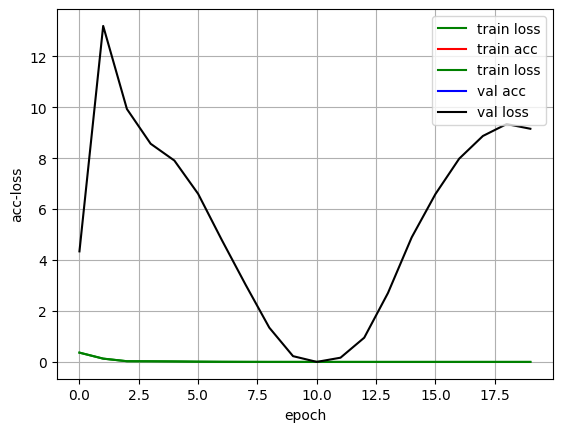

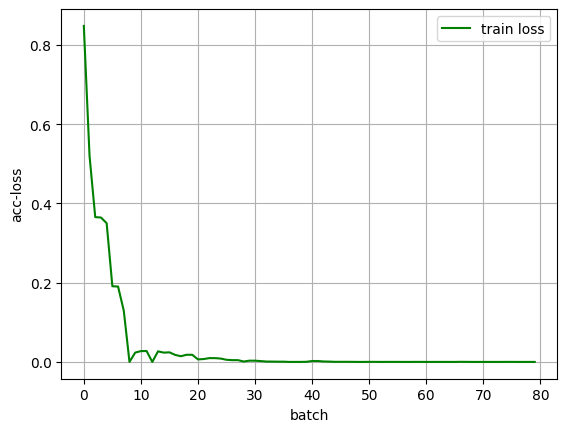

In [16]:
inception(num_class=2,epochs=20)	#binary classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

***InceptionResnet***

In [17]:
def inceptionresnet( num_class, epochs,savepath='./inceptionresnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:500]:	#the number of frozen layers for transfer learning, have tuned from 400-550
        layer.trainable = False
    for layer in model_fine_tune.layers[500:]:	#the number of trainable layers for transfer learning
        layer.trainable = True
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(1, activation='sigmoid')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	#tuned learning rate to be 0.001
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) #set the loss function to be binary crossentropy
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_acc', patience=2, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_acc',
        verbose=1,
        save_best_only=False,
        mode='auto')
    start_time = time.time()

    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f'Total training time: {training_time} seconds')

Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.8623 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 1: saving model to .\inceptionresnet.h5
4/4 [==============================] - 96s 21s/step - loss: 0.2777 - accuracy: 0.8623 - val_loss: 0.7810 - val_accuracy: 0.9429
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9792WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 2: saving model to .\inceptionresnet.h5
4/4 [==============================] - 76s 20s/step - loss: 0.0965 - accuracy: 0.9792 - val_loss: 0.6875 - val_accuracy: 0.9377
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.9844 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 3: saving model to .\inceptionresnet.h5
4/4 [==============================] - 77s 20s/step - loss: 0.0672 - accuracy: 0.9844 - val_loss: 3.2167 - val_accuracy: 0.5221
Epoch 4/20
4/4 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 1.0000  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 4: saving model to .\inceptionresnet.h5
4/4 [==============================] - 75s 25s/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 18.4213 - val_accuracy: 0.1948
Epoch 5/20
4/4 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 5: saving model to .\inceptionresnet.h5
4/4 [==============================] - 81s 22s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 39.4634 - val_accuracy: 0.0857
Epoch 6/20
4/4 [==============================] - ETA: 0s - loss: 3.4238e-04 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 6: saving model to .\inceptionresnet.h5
4/4 [==============================] - 81s 21s/step - loss: 3.4238e-04 - accuracy: 1.0000 - val_loss: 19.3344 - val_accuracy: 0.0857
Epoch 7/20
4/4 [==============================] - ETA: 0s - loss: 1.5553e-04 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 7: saving model to .\inceptionresnet.h5
4/4 [==============================] - 77s 21s/step - loss: 1.5553e-04 - accuracy: 1.0000 - val_loss: 12.3087 - val_accuracy: 0.9377
Epoch 8/20
4/4 [==============================] - ETA: 0s - loss: 7.6207e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 8: saving model to .\inceptionresnet.h5
4/4 [==============================] - 75s 20s/step - loss: 7.6207e-05 - accuracy: 1.0000 - val_loss: 51.2189 - val_accuracy: 0.9377
Epoch 9/20
4/4 [==============================] - ETA: 0s - loss: 2.9661e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 9: saving model to .\inceptionresnet.h5
4/4 [==============================] - 76s 20s/step - loss: 2.9661e-05 - accuracy: 1.0000 - val_loss: 83.0498 - val_accuracy: 0.9377
Epoch 10/20
4/4 [==============================] - ETA: 0s - loss: 2.5741e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 10: saving model to .\inceptionresnet.h5
4/4 [==============================] - 76s 20s/step - loss: 2.5741e-05 - accuracy: 1.0000 - val_loss: 86.0768 - val_accuracy: 0.9377
Epoch 11/20
4/4 [==============================] - ETA: 0s - loss: 2.7377e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 11: saving model to .\inceptionresnet.h5
4/4 [==============================] - 76s 20s/step - loss: 2.7377e-05 - accuracy: 1.0000 - val_loss: 69.5292 - val_accuracy: 0.9377
Epoch 12/20
4/4 [==============================] - ETA: 0s - loss: 7.3063e-05 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 12: saving model to .\inceptionresnet.h5
4/4 [==============================] - 75s 25s/step - loss: 7.3063e-05 - accuracy: 1.0000 - val_loss: 54.8521 - val_accuracy: 0.9377
Epoch 13/20
4/4 [==============================] - ETA: 0s - loss: 1.7558e-05 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 13: saving model to .\inceptionresnet.h5
4/4 [==============================] - 82s 21s/step - loss: 1.7558e-05 - accuracy: 1.0000 - val_loss: 43.9896 - val_accuracy: 0.9377
Epoch 14/20
4/4 [==============================] - ETA: 0s - loss: 3.7843e-05 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 14: saving model to .\inceptionresnet.h5
4/4 [==============================] - 75s 25s/step - loss: 3.7843e-05 - accuracy: 1.0000 - val_loss: 31.5512 - val_accuracy: 0.9377
Epoch 15/20
4/4 [==============================] - ETA: 0s - loss: 1.2854e-05 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 15: saving model to .\inceptionresnet.h5
4/4 [==============================] - 76s 20s/step - loss: 1.2854e-05 - accuracy: 1.0000 - val_loss: 24.4211 - val_accuracy: 0.9377
Epoch 16/20
4/4 [==============================] - ETA: 0s - loss: 2.3414e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 16: saving model to .\inceptionresnet.h5
4/4 [==============================] - 76s 20s/step - loss: 2.3414e-05 - accuracy: 1.0000 - val_loss: 15.7475 - val_accuracy: 0.9377
Epoch 17/20
4/4 [==============================] - ETA: 0s - loss: 2.4042e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 17: saving model to .\inceptionresnet.h5
4/4 [==============================] - 83s 23s/step - loss: 2.4042e-05 - accuracy: 1.0000 - val_loss: 12.7262 - val_accuracy: 0.9377
Epoch 18/20
4/4 [==============================] - ETA: 0s - loss: 6.1092e-06 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 18: saving model to .\inceptionresnet.h5
4/4 [==============================] - 78s 21s/step - loss: 6.1092e-06 - accuracy: 1.0000 - val_loss: 12.1530 - val_accuracy: 0.9377
Epoch 19/20
4/4 [==============================] - ETA: 0s - loss: 1.2375e-05 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 19: saving model to .\inceptionresnet.h5
4/4 [==============================] - 75s 20s/step - loss: 1.2375e-05 - accuracy: 1.0000 - val_loss: 10.3859 - val_accuracy: 0.9377
Epoch 20/20
4/4 [==============================] - ETA: 0s - loss: 1.5919e-05 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy



Epoch 20: saving model to .\inceptionresnet.h5
4/4 [==============================] - 75s 20s/step - loss: 1.5919e-05 - accuracy: 1.0000 - val_loss: 8.2970 - val_accuracy: 0.9377
Total training time: 1562.8525516986847 seconds


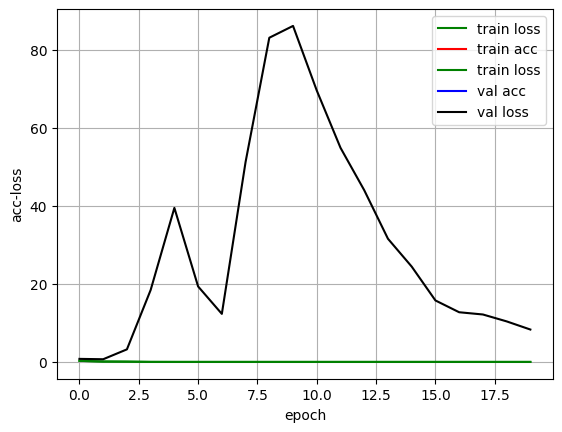

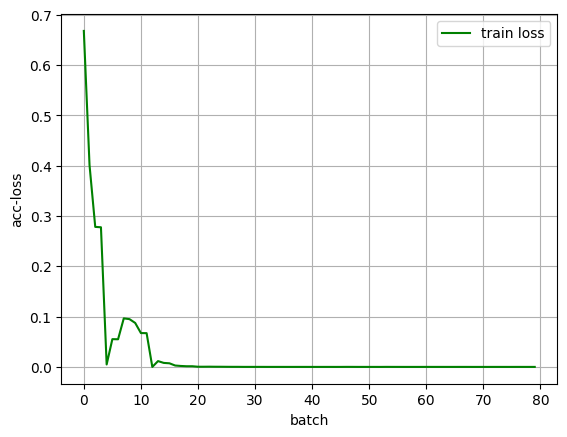

In [18]:
inceptionresnet(num_class=2,epochs=20)	# 5-class classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()